In [1]:
import gym, gym_unbalanced_disk, time
import numpy as np
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
target_angle=np.pi
reward_fun =  lambda self: ((np.cos(self.th-target_angle)+1.5)*2 - 0.25) + 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2) - 0.01*((self.u)**2)


In [3]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))+np.pi

In [4]:
env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3., reward_fun=reward_fun) 

In [8]:
u_list=[-3]*12+[3]*10+[0]+[-0.9]*3+[0]*100  # sim
# ulist=[-3]*10+[3]*10+[1.5]*3+[-1]*5+[0]*10 # irl

In [9]:
obs = env.reset()
thetas=[]
omegas=[]
rewards=[]
try:
    for u in u_list:
        obs, reward, done, info = env.step(u)
        env.render()
        thetas.append((obs[0]))
        omegas.append(obs[1])
        rewards.append(reward)
        time.sleep(1/50)
        if done:
            obs=env.reset()
finally:
    env.close()

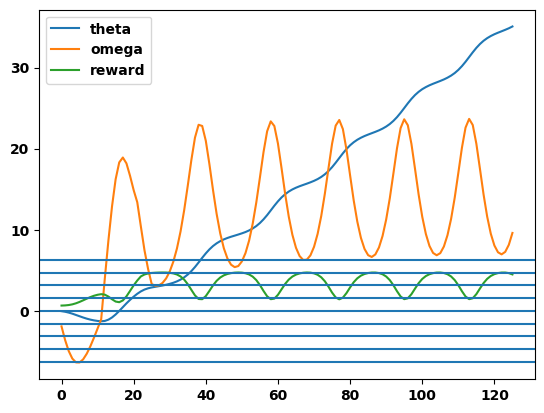

In [10]:
plt.plot(thetas, label='theta')
plt.plot(omegas, label='omega')
plt.plot(rewards, label='reward')
[plt.axhline(x) for x in np.arange(-2,2.1,0.5)*np.pi]

plt.legend()

In [278]:
@dataclass
class Data:
    th = None
    omega = None
    u = None

In [279]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))-np.pi

def compute_reward(self):
        abs_q=abs(normalise_angle(self.th))
        abs_dq=abs(self.omega)

        # reward
        r = lambda q_, dq_: -(q_**2 + 0.01*dq_**2)
        if abs_q<np.pi*2/3:
            reward= r(abs_q,abs_dq)+500
        else:
            reward= -(r(np.pi*2/3,4)-1.0*(4.0-abs_dq)**2)

        return reward

In [280]:
def compute_reward(self):
    q=normalise_angle(self.th)
    if abs(q)<np.pi/3:
        return 800 - 0.1*self.omega**2+(self.u/self.omega)**2
    else:
        return q**2+1*self.omega**2+self.u**2+1*(self.u/self.omega)**2

In [281]:
# backup:
# def compute_reward(self,test=False):
#     q = normalise_angle(self.th)
#     theta=self.th
#     omega = self.th
#     u = self.u
#     if abs(q) > 2 * np.pi / 3:  # lower 120
#         c=0
#         r = 0.7*omega*u -1.5*omega#-q**2#  +u**2
#         if u > 0:
#             r+=7
#     elif abs(q) > np.pi / 3:  # either side
#         c=1
#         r = omega**2+0.1*u**2+0.5*q**2# - q**2
#         if u >0 and theta > 0:
#             r+=4*theta
#         if abs(omega) < 0.8:
#             r = omega * (-self.u)
#     else:  # top
#         c=2
#         r = 11-q**2 + 0.5*omega**2
#     if test:
#         return q, r, c
#     else:
#         return r

In [307]:
def compute_reward(self,test=False):
    q = normalise_angle(self.th)
    theta=self.th
    omega = self.omega
    u = self.u
    if abs(q) > 2 * np.pi / 3:  # lower 120
        c=0
        r = omega*u -u#-q**2#  +u**2
    elif abs(q) > np.pi / 3:  # either side
        c=1
        r = 0.1*omega**2+0.1*u**2+0.5*q**2# - q**2
    else:  # top
        c=2
        r = 10-q**2 - 0.01*omega**2
    if test:
        return q, r, c
    else:
        return r

In [443]:
def get_color(q):
    if abs(q) > 2 * np.pi / 3:  # lower 120
        c=0
    elif abs(q) > np.pi / 3:  # either side
        c=1
    else:  # top
        c=2
    return c

def compute_reward_sim(self):
    q = normalise_angle(self.th)
    r=compute_reward(self)
    c=get_color(q)
    return q, r, c

In [483]:
def compute_reward(self):
    q = normalise_angle(self.th)
    theta=self.th
    omega = self.omega
    u = self.u

    r=-q**2 +0.1*u**2-u

    if abs(q) > 2 * np.pi / 3:  # lower 120
        r=-q**2 +0.1*u**2+0.1*omega**2
        if (omega)>5: r=0.5*omega+u+theta
        r/=10
    elif abs(q) > np.pi / 3:  # either side
        r=-6*abs(q) +0.3*omega
        r/=6
        r+=2.5
    else:  # top
        r-=5*abs(q)+1*omega**2-u**2
        r/=30
        r+=10

    return r

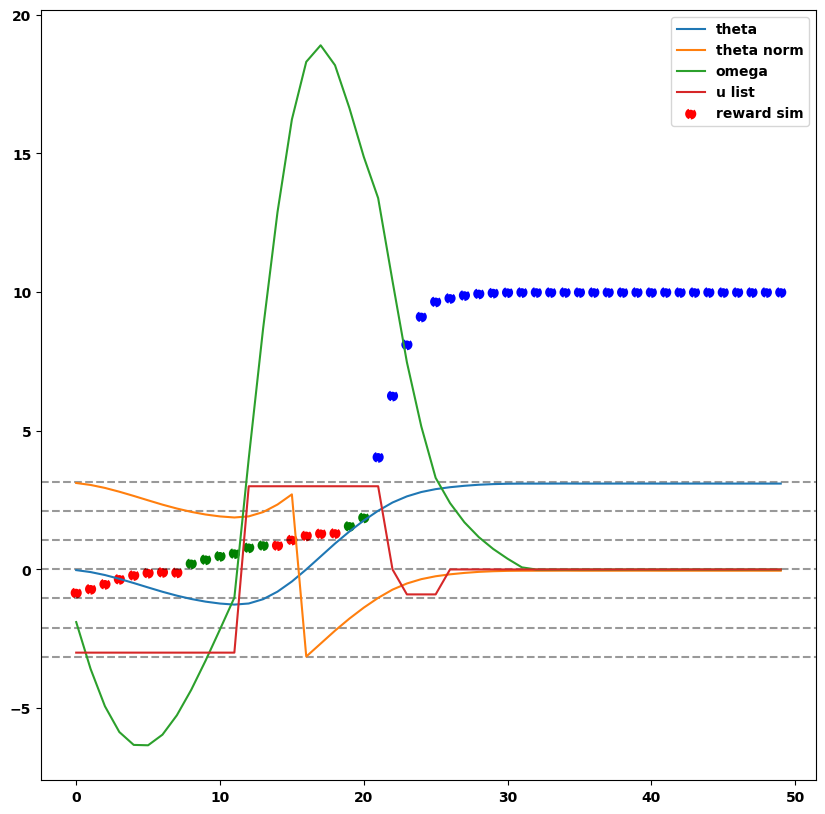

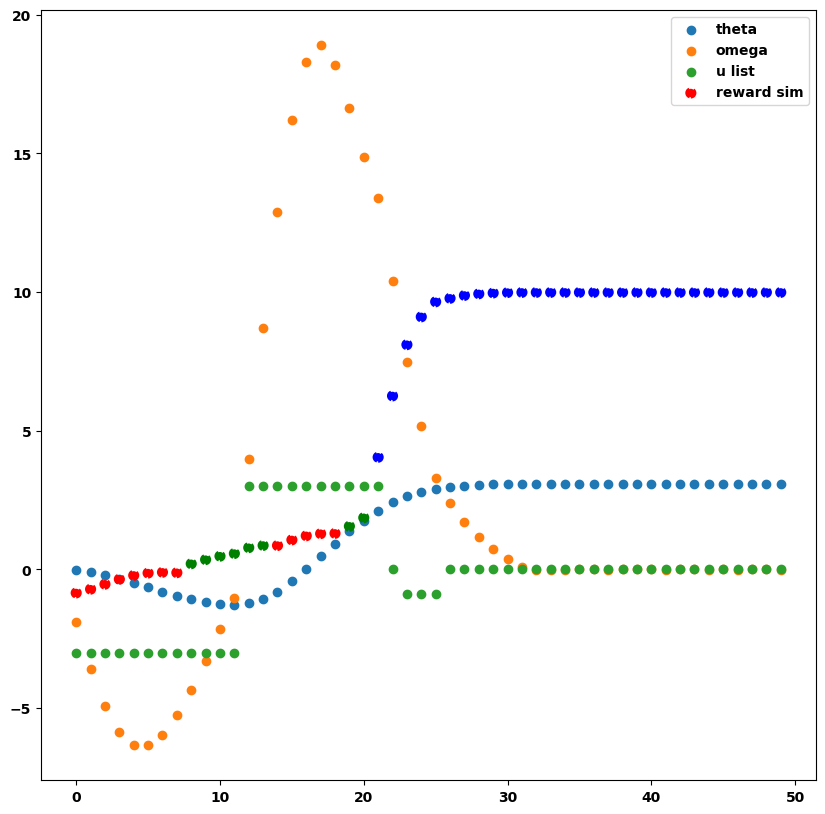

In [485]:
rewards_sim=[]
colors=[]
thetas_norm=[]
colormap = np.array(['r', 'g', 'b'])
plot_end=50
fig_side=10
for i in range(len(u_list)-plot_end):
    data=Data()
    data.th=thetas[i]
    data.omega=omegas[i]
    data.u=u_list[i]
    q, r,c = compute_reward_sim(data)
    rewards_sim.append(r)
    colors.append(c)
    thetas_norm.append(q)
x=[*range(len(u_list[:plot_end]))]

rewards_sim=np.array(rewards_sim)
rewards_sim=rewards_sim

plt.figure(figsize=(fig_side,fig_side))
[plt.axhline(x, ls='--',c='black',alpha=0.4) for x in np.arange(-1,1.1,1/3)*np.pi]

plt.plot(thetas[:plot_end], label='theta')
plt.plot(thetas_norm[:plot_end], label='theta norm')
plt.plot(omegas[:plot_end], label='omega')
# plt.plot(np.array(omegas[:plot_end])**2, label='omega^2')
plt.plot(u_list[:plot_end], label='u list')
# plt.plot(rewards, linewidth=2, label='reward')
plt.scatter(x, rewards_sim[:plot_end], ls='--', linewidth=2, label='reward sim', c= colormap[colors[:plot_end]])
plt.legend()
plt.show()
plt.figure(figsize=(fig_side,fig_side))
plt.scatter(x,thetas[:plot_end], label='theta')
# plt.scatter(x,thetas_norm[:plot_end], label='theta norm')
plt.scatter(x,omegas[:plot_end], label='omega')
# plt.scatter(x,np.array(omegas[:plot_end])**2, label='omega^2')
plt.scatter(x,u_list[:plot_end], label='u list')
# plt.scatter(x,rewards, linewidth=2, label='reward')
plt.scatter(x, rewards_sim[:plot_end], ls='--', linewidth=2, label='reward sim', c= colormap[colors[:plot_end]])
plt.legend()
plt.show()